In [837]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import ast


from pprint import pprint

import sys 
sys.path.insert(1, "../")
from workloads.util import use_results, use_dataset, read_config, log_dataset, join_queries_features
from workloads.recsys.recsys_util import get_features, get_feature_update

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1018]:
experiment = "results_workers_1_fifo-100_learningrate_0.02_userfeaturereg_0.01_sleep_0.1"

In [1013]:
dataset_dir = use_dataset("ml-100k-features")
results_dir = use_results("ml-100k-features")
print(dataset_dir)
print(results_dir)

/data/wooders/ralf-vldb//datasets/ml-100k-features
/data/wooders/ralf-vldb//datasets/ml-100k-features
/data/wooders/ralf-vldb//results/ml-100k-features


In [1014]:
feature_updates = pd.read_csv(f"{results_dir}/{experiment}.csv")

In [1015]:
(feature_updates["processing_time"] - feature_updates["ingest_time"]).min()

0.010963201522827148

In [1016]:
feature_updates["runtime"].median()

4.2438507080078125e-05

<AxesSubplot:>

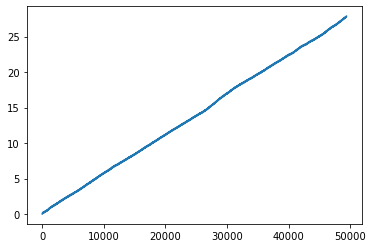

In [1019]:
(feature_updates["processing_time"] - feature_updates["ingest_time"]).plot()

In [1020]:
feature_updates

,user_id,user_features,ingest_time,timestamp,processing_time,runtime
0,23,"[0.15482563891340984, 0.05535640001818538, 0.4...",1.645768e+09,0,1.645768e+09,0.000403
1,712,"[0.0002096466615135222, 0.00028415484285569106...",1.645768e+09,0,1.645768e+09,0.000559
2,23,"[0.15479467378562714, 0.05534532873818174, 0.3...",1.645768e+09,0,1.645768e+09,0.000106
3,23,"[0.15522122025413182, 0.05555949335159488, 0.3...",1.645768e+09,0,1.645768e+09,0.000171
4,23,"[0.1564798129758787, 0.0562868987549113, 0.404...",1.645768e+09,0,1.645768e+09,0.000026
...,...,...,...,...,...,...
49369,189,"[0.4716665622302191, 0.16804584587440224, 0.57...",1.645768e+09,493,1.645768e+09,0.000071
49370,189,"[0.4785094148124819, 0.16804369170711547, 0.57...",1.645768e+09,493,1.645768e+09,0.000036
49371,189,"[0.48938306796796477, 0.17332378622492675, 0.5...",1.645768e+09,493,1.645768e+09,0.000036
49372,189,"[0.4783503205237642, 0.16796145927397402, 0.57...",1.645768e+09,493,1.645768e+09,0.000064


<AxesSubplot:>

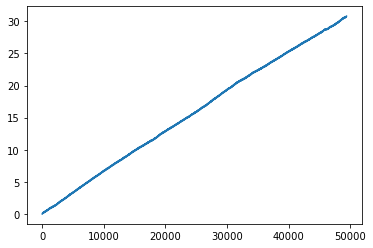

In [1011]:
(feature_updates["processing_time"] - feature_updates["ingest_time"]).plot()

In [976]:
feature_updates["user_features"] = feature_updates["user_features"].apply(ast.literal_eval)

In [977]:
# create map to map timestamps -> real timestamps 
timestamp_to_ingest_time = dict(zip(feature_updates.timestamp, feature_updates.ingest_time))
#pprint(timestamp_to_ingest_time)

In [978]:
feature_updates

,user_id,user_features,ingest_time,timestamp,processing_time,runtime
0,23,"[0.1558862970918417, 0.05535640001818538, 0.39...",1.645763e+09,0,1.645763e+09,0.000317
1,23,"[0.1551610140794084, 0.05534532873818174, 0.39...",1.645763e+09,0,1.645763e+09,0.000481
2,712,"[0.0002096466615135222, 0.00028415484285569106...",1.645763e+09,0,1.645763e+09,0.001360
3,23,"[0.15557652164489713, 0.05555409487916563, 0.3...",1.645763e+09,0,1.645763e+09,0.000261
4,23,"[0.15235903474731152, 0.05440107056555858, 0.3...",1.645763e+09,0,1.645763e+09,0.000245
...,...,...,...,...,...,...
49393,189,"[0.4889430204582552, 0.16718254040357072, 0.59...",1.645763e+09,493,1.645763e+09,0.000263
49394,189,"[0.4873183415502107, 0.16542044069424516, 0.59...",1.645763e+09,493,1.645763e+09,0.000367
49395,189,"[0.48722087788190066, 0.16532569765679014, 0.5...",1.645763e+09,493,1.645763e+09,0.000230
49396,189,"[0.4869700032499095, 0.16482058779312322, 0.59...",1.645763e+09,493,1.645763e+09,0.000332


## Read Batch Generated Features Data 

In [979]:
user_features_path = f"{dataset_dir}/user_features.csv"
movie_features_path = f"{dataset_dir}/movie_features.csv"
ratings_path = f"{dataset_dir}/ratings.csv"

In [980]:
user_features = get_features(user_features_path)
movie_features = get_features(movie_features_path)

### Join with feature updates file 
This is to make sure every query gets matched to *some* user feature in later steps. 

In [981]:
for user_id in user_features.keys(): 
    # concate feature for time 0 
    row = pd.DataFrame({"user_id": user_id, "user_features": [user_features[user_id]], "processing_time": 0})
    feature_updates = pd.concat([feature_updates, row])

In [982]:
feature_updates.sort_values(by="processing_time")

,user_id,user_features,ingest_time,timestamp,processing_time,runtime
0,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.000000e+00,NaN
0,321,"[0.26818186044692993, 0.09138399362564087, 0.1...",NaN,NaN,0.000000e+00,NaN
0,320,"[0.0, 0.2277950793504715, 0.39908701181411743,...",NaN,NaN,0.000000e+00,NaN
0,319,"[0.1219610646367073, 0.11494453251361847, 0.06...",NaN,NaN,0.000000e+00,NaN
0,318,"[0.0, 0.1581413596868515, 0.280290812253952, 0...",NaN,NaN,0.000000e+00,NaN
...,...,...,...,...,...,...
49393,189,"[0.4889430204582552, 0.16718254040357072, 0.59...",1.645763e+09,493.0,1.645763e+09,0.000263
49394,189,"[0.4873183415502107, 0.16542044069424516, 0.59...",1.645763e+09,493.0,1.645763e+09,0.000367
49395,189,"[0.48722087788190066, 0.16532569765679014, 0.5...",1.645763e+09,493.0,1.645763e+09,0.000230
49396,189,"[0.4869700032499095, 0.16482058779312322, 0.59...",1.645763e+09,493.0,1.645763e+09,0.000332


## Read Test Data (i.e. queries)

In [983]:
test_data = pd.read_csv(ratings_path)

In [984]:
# assign query timestamps based of ingest_time of feature timestamps 
queries_df = pd.DataFrame({
    "user_id": test_data.user_id, 
    "movie_id": test_data.movie_id, 
    "rating": test_data.rating, 
    "timestamp": test_data.timestamp, 
    "processing_time": test_data.timestamp.apply(lambda x: timestamp_to_ingest_time[x] if x in timestamp_to_ingest_time else None)
})
queries_df = queries_df.dropna()
queries_df["query_id"] = queries_df.index
queries_df

,user_id,movie_id,rating,timestamp,processing_time,query_id
0,712,506,3,0,1.645763e+09,0
1,23,739,2,0,1.645763e+09,1
2,23,530,4,0,1.645763e+09,2
3,23,211,4,0,1.645763e+09,3
4,23,511,5,0,1.645763e+09,4
...,...,...,...,...,...,...
49394,189,381,3,493,1.645763e+09,49394
49395,189,378,4,493,1.645763e+09,49395
49396,189,526,4,493,1.645763e+09,49396
49397,189,28,4,493,1.645763e+09,49397


In [985]:
start_ts = feature_updates.processing_time.min()
queries_df.processing_time - start_ts

0        1.645763e+09
1        1.645763e+09
2        1.645763e+09
3        1.645763e+09
4        1.645763e+09
             ...     
49394    1.645763e+09
49395    1.645763e+09
49396    1.645763e+09
49397    1.645763e+09
49398    1.645763e+09
Name: processing_time, Length: 49399, dtype: float64

In [986]:
feature_updates.processing_time - start_ts

0    1.645763e+09
1    1.645763e+09
2    1.645763e+09
3    1.645763e+09
4    1.645763e+09
         ...     
0    0.000000e+00
0    0.000000e+00
0    0.000000e+00
0    0.000000e+00
0    0.000000e+00
Name: processing_time, Length: 50341, dtype: float64

### Modify query processing time 
Probably more realistic to add a slight delay between when the update is sent to ralf (ingest_time) and when the query is made? 

In [987]:
# NOTE: don't actually do this since this means features have seen the ground truth label 
#queries_df["processing_time"] = queries_df["processing_time"] + 1

### Join queries with feature updates 

In [988]:
tmp_joined_df = join_queries_features(queries_df, feature_updates, key_field="user_id", time_field="processing_time")

100%|██████████| 49399/49399 [01:00<00:00, 815.16it/s]


In [989]:
joined_df = tmp_joined_df.merge(queries_df, on=["query_id", "user_id"], suffixes=("_feature", "_query"))

In [990]:
joined_df

,user_id,user_features,ingest_time,timestamp_feature,processing_time_feature,runtime,query_id,query_user_id,query_timestamp,movie_id,rating,timestamp_query,processing_time_query
0,1,"[0.2996620237827301, 0.047908809036016464, 0.2...",NaN,NaN,0.0,NaN,4599,1.0,1.645763e+09,46,4,46,1.645763e+09
1,1,"[0.2996620237827301, 0.047908809036016464, 0.2...",NaN,NaN,0.0,NaN,4600,1.0,1.645763e+09,177,5,46,1.645763e+09
2,1,"[0.2996620237827301, 0.047908809036016464, 0.2...",NaN,NaN,0.0,NaN,4602,1.0,1.645763e+09,195,5,46,1.645763e+09
3,1,"[0.2996620237827301, 0.047908809036016464, 0.2...",NaN,NaN,0.0,NaN,4604,1.0,1.645763e+09,213,2,46,1.645763e+09
4,1,"[0.2996620237827301, 0.047908809036016464, 0.2...",NaN,NaN,0.0,NaN,4605,1.0,1.645763e+09,218,3,46,1.645763e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49394,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.0,NaN,37291,943.0,1.645763e+09,229,2,372,1.645763e+09
49395,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.0,NaN,37292,943.0,1.645763e+09,449,1,372,1.645763e+09
49396,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.0,NaN,37293,943.0,1.645763e+09,234,3,372,1.645763e+09
49397,943,"[0.14470918476581573, 0.145412877202034, 0.220...",NaN,NaN,0.0,NaN,37294,943.0,1.645763e+09,151,4,372,1.645763e+09


### Evaluate on all queries 

In [991]:
joined_df.processing_time_feature.value_counts()

0.000000e+00    46243
1.645763e+09      122
1.645763e+09       98
1.645763e+09       89
1.645763e+09       85
                ...  
1.645763e+09        1
1.645763e+09        1
1.645763e+09        1
1.645763e+09        1
1.645763e+09        1
Name: processing_time_feature, Length: 196, dtype: int64

In [992]:
joined_df["prediction"] = joined_df.apply(
    lambda x: predict_rating(np.array(x["user_features"]), movie_features[x["movie_id"]])
, axis=1) 

In [993]:
joined_df["baseline_prediction"] = joined_df.apply(
    lambda x: predict_rating(user_features[x["user_id"]], movie_features[x["movie_id"]])
, axis=1) 

In [994]:
joined_df.processing_time_feature.value_counts()

0.000000e+00    46243
1.645763e+09      122
1.645763e+09       98
1.645763e+09       89
1.645763e+09       85
                ...  
1.645763e+09        1
1.645763e+09        1
1.645763e+09        1
1.645763e+09        1
1.645763e+09        1
Name: processing_time_feature, Length: 196, dtype: int64

In [995]:
mean_squared_error(joined_df["rating"], joined_df["prediction"])

0.9647144471024635

In [996]:
mean_squared_error(joined_df["rating"], joined_df["baseline_prediction"])

0.963470348046898

### Evaluate on queries of updated features 

In [997]:
joined_df_drop = joined_df[joined_df["processing_time_feature"] > 0]

In [998]:
staleness = joined_df_drop["timestamp_query"] - joined_df_drop["timestamp_feature"]
print("average staleness", staleness.mean())
joined_df_drop.processing_time_feature.value_counts()

average staleness 201.11470215462612


1.645763e+09    122
1.645763e+09     98
1.645763e+09     89
1.645763e+09     85
1.645763e+09     82
               ... 
1.645763e+09      1
1.645763e+09      1
1.645763e+09      1
1.645763e+09      1
1.645763e+09      1
Name: processing_time_feature, Length: 195, dtype: int64

In [999]:
staleness.value_counts()

113.0    109
5.0       88
7.0       83
204.0     60
236.0     55
        ... 
314.0      1
159.0      1
378.0      1
67.0       1
56.0       1
Length: 275, dtype: int64

In [1000]:
mean_squared_error(joined_df_drop["rating"], joined_df_drop["prediction"])

1.070650370423417

In [1001]:
mean_squared_error(joined_df_drop["rating"], joined_df_drop["baseline_prediction"])

1.051177224274537

<AxesSubplot:>

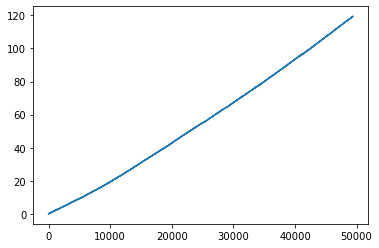

In [1002]:
(feature_updates["processing_time"] - feature_updates["ingest_time"]).plot()

# Old Evaluation 
Copied from Amit's Notebook

In [686]:
user_features = get_features(user_features_path)
movie_features = get_features(movie_features_path)

def predict_rating(user_feature, movie_feature):
    return user_feature.dot(movie_feature.T)

def compute_test_mse(user_features, movie_features):
    predictions = []
    ratings = []
    count = 0
    for row in test_data.itertuples():
        user_id = row.user_id
        movie_id = row.movie_id
        rating = row.rating
        predictions.append(predict_rating(user_features[user_id], movie_features[movie_id]))
        ratings.append(rating) 
    mse = mean_squared_error(ratings, predictions)
    return mse

def compute_mse(user_features):
    predictions = []
    ratings = []
    for row in test_data.itertuples():
        user_id = row.user_id
        movie_id = row.movie_id
        rating = row.rating
        ratings.append(rating)
        predictions.append(predict_rating(user_features[user_id], movie_features[movie_id]))
    return mean_squared_error(ratings, predictions)

def compute_improvement():
    count = 0
    predictions = []
    ratings = []
    max_timestamp = max(feature_updates['timestamp'])
    print(max_timestamp, len(feature_updates), len(test_data))
    baseline = compute_mse(user_features)
    
    
    num_updates = 0 
    while count <= max_timestamp:
        
        # 
        feature_update_ts = feature_updates[feature_updates['timestamp'] == count] 
        for row in feature_update_ts.itertuples():
            user_features[row.user_id] = np.array(row.user_features)
            num_updates += 1

        query_ts = test_data[test_data['timestamp'] == count]
        for row in query_ts.itertuples():
            user_id = row.user_id
            movie_id = row.movie_id
            rating = row.rating
            predictions.append(predict_rating(user_features[user_id], movie_features[movie_id]))
            ratings.append(rating)
        count += 1
    new_mse = mean_squared_error(ratings, predictions)
    optimal = compute_mse(user_features)
    
    return baseline, new_mse, optimal

In [421]:
def plot_learning_curve(mse):
        """visualize the training/testing loss"""
        linewidth = 3
        plt.plot(mse, label = 'Ralf', linewidth = linewidth)
        plt.xlabel('iterations')
        plt.ylabel('MSE')
        plt.legend(loc = 'best')

493.0 51260 49442


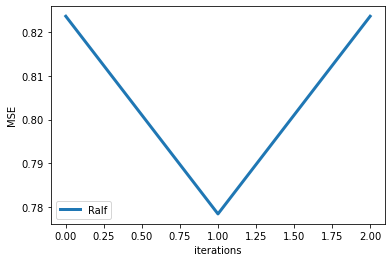

In [422]:
mse = compute_improvement()
plot_learning_curve(mse)

In [797]:
queries_df[queries_df["user_id"] == 1]

,user_id,movie_id,rating,timestamp,processing_time,query_id
4599,1,46,4,46,1.645730e+09,4599
4600,1,177,5,46,1.645730e+09,4600
4602,1,195,5,46,1.645730e+09,4602
4604,1,213,2,46,1.645730e+09,4604
4605,1,218,3,46,1.645730e+09,4605
...,...,...,...,...,...,...
39574,1,171,5,395,1.645730e+09,39574
39577,1,256,4,395,1.645730e+09,39577
39579,1,5,3,395,1.645730e+09,39579
39581,1,74,1,395,1.645730e+09,39581


In [798]:
feature_updates[feature_updates["user_id"] == 1]

,user_id,user_features,ingest_time,timestamp,processing_time
4599,1,"[0.3019014918853027, 0.05003575478712979, 0.28...",1.645730e+09,46,1.645730e+09
4600,1,"[0.30867132343194786, 0.0512892869593834, 0.29...",1.645730e+09,46,1.645730e+09
4601,1,"[0.30103999521561997, 0.05106405723943165, 0.2...",1.645730e+09,46,1.645730e+09
4604,1,"[0.29775366186730057, 0.04700179361262008, 0.2...",1.645730e+09,46,1.645730e+09
4607,1,"[0.2914662294252006, 0.05081714243951459, 0.28...",1.645730e+09,46,1.645730e+09
...,...,...,...,...,...
39471,1,"[0.2847213856932706, 0.05979953728922165, 0.29...",1.645730e+09,395,1.645730e+09
39579,1,"[0.3108469812052534, 0.03613532715239847, 0.30...",1.645730e+09,395,1.645730e+09
39582,1,"[0.31078481180901235, 0.03613147075465142, 0.3...",1.645730e+09,395,1.645730e+09
39791,1,"[0.3206572641287867, 0.04658908309605972, 0.31...",1.645730e+09,395,1.645730e+09


In [806]:
joined_df[joined_df["user_id"] == 1]

,user_id,user_features,ingest_time,timestamp_feature,processing_time_feature,query_id,query_user_id,query_timestamp,movie_id,rating,timestamp_query,processing_time_query
0,1,"[0.30752268632733987, 0.05102583386629647, 0.2...",1.645730e+09,55,1.645730e+09,4599,1.0,1.645730e+09,46,4,46,1.645730e+09
1,1,"[0.30752268632733987, 0.05102583386629647, 0.2...",1.645730e+09,55,1.645730e+09,4600,1.0,1.645730e+09,177,5,46,1.645730e+09
2,1,"[0.30752268632733987, 0.05102583386629647, 0.2...",1.645730e+09,55,1.645730e+09,4602,1.0,1.645730e+09,195,5,46,1.645730e+09
3,1,"[0.30752268632733987, 0.05102583386629647, 0.2...",1.645730e+09,55,1.645730e+09,4604,1.0,1.645730e+09,213,2,46,1.645730e+09
4,1,"[0.30752268632733987, 0.05102583386629647, 0.2...",1.645730e+09,55,1.645730e+09,4605,1.0,1.645730e+09,218,3,46,1.645730e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
130,1,"[0.2847213856932706, 0.05979953728922165, 0.29...",1.645730e+09,395,1.645730e+09,39574,1.0,1.645730e+09,171,5,395,1.645730e+09
131,1,"[0.2847213856932706, 0.05979953728922165, 0.29...",1.645730e+09,395,1.645730e+09,39577,1.0,1.645730e+09,256,4,395,1.645730e+09
132,1,"[0.2847213856932706, 0.05979953728922165, 0.29...",1.645730e+09,395,1.645730e+09,39579,1.0,1.645730e+09,5,3,395,1.645730e+09
133,1,"[0.2847213856932706, 0.05979953728922165, 0.29...",1.645730e+09,395,1.645730e+09,39581,1.0,1.645730e+09,74,1,395,1.645730e+09
